# Tutorial 5 - Recurrent Neural Networks

This tutorial is split into three parts. Parts A and B were covered in the lecture and focus on Word2Vec and GloVe word embeddings. Sentiment analysis using GloVe embeddings with a simple ANN classifier is the focus of Part B. Part C introduces recurrent neural networks (RNNs) for sentiment analysis and provides sample code for batching of data.

# Part A: Word2Vec and GloVe Vectors
We saw how autoencoders are used to learn a latent
**embedding space**: an alternative, low-dimensional representation
of a set of data with some appealing properties:
for example, we saw that interpolating in the latent space
is a way of generating new examples. In particular,
interpolation in the latent space generates more compelling
examples than, say, interpolating in the raw pixel space.

The idea of learning an alternative representation/features/*embeddings* of data
is a prevalent one in machine learning. Good representations will
make downstream tasks (like generating new data, clustering, computing distances) perform much better.

With autoencoders, we were able to learn a representation of MNIST digits.
In lab 4, we use an autoencoder to learn a representation of a census record.
In both cases, we used a model that looks like this:

- **Encoder**: data -> embedding
- **Decoder**: embedding -> data

This type of architecture works well for certain types of data (e.g. images)
that are easy to generate, and whose meaning is encoded in the input data
representation (e.g. the pixels).

But what if we want to train an embedding on words? Words are different
from images, in that the meaning of a word is not represented
by the letters that make up the word (the same way that the meaning
of an image is represented by the pixels that make up the pixel). Instead,
the meaning of words comes from how they are used in conjunction with other
words.

## word2vec models

A word2vec model learns embedding of words using the following architecture:

- **Encoder**: word -> embedding
- **Decoder**: embedding -> nearby words (context)

Specific word2vec models differ in the which "nearby words" is predicted
using the decoder: is it the 3 context words that appeared *before*
the input word? Is it the 3 words that appeared *after*? Or is it a combination
of the two words that appeared before and two words that appeared after
the input word?

These models are trained using a large corpus of text: for example the whole
of Wikipedia or a large collection of news articles. We won't train our
own word2vec models in this course, so we won't talk about the many considerations involved in training a word2vec model.

Instead, we will use a set of pre-trained word embeddings. These are embeddings
that someone else took the time and computational power to train.
One of the most commonly-used pre-trained word embeddings are the **GloVe embeddings**.

GloVe is a variation of a word2vec model. Again, the specifics of the algorithm
and its training will be beyond the scope of this course.
You should think of **GloVe embeddings** similarly to pre-trained AlexNet weights in that they "may" provide improvements to the representation of data.

More information about GloVe is available here: https://nlp.stanford.edu/projects/glove/

Unlike AlexNet, there are several variations of GloVe embeddings. They
differ in the corpus used to train the embedding, and the *size* of the embeddings.

## GloVe Embeddings

To load pre-trained GloVe embeddings, we'll use a package called `torchtext`.
The package `torchtext` contains other useful tools for working with text
that we will see later in the course. The documentation for torchtext
GloVe vectors are available at: https://torchtext.readthedocs.io/en/latest/vocab.html#glove

We'll begin by loading a set of GloVe embeddings. The first time you run the code below, Python will download a large file (862MB) containing the pre-trained embeddings.

In [1]:
import torch
import torchtext
from torchtext.vocab import GloVe

# The first time you run this will download a ~823MB file
glove = GloVe(name="6B", # trained on Wikipedia 2014 corpus
                      dim=50) # embedding size = 50

c:\Users\0xc00\.conda\envs\APS360\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\0xc00\.conda\envs\APS360\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
.vector_cache\glove.6B.zip: 862MB [05:33, 2.59MB/s]                               
100%|█████████▉| 399999/400000 [00:07<00:00, 55374

Let's look at what the embedding of the word "car" looks like:

In [2]:
glove['car']

tensor([ 0.4769, -0.0846,  1.4641,  0.0470,  0.1469,  0.5082, -1.2228, -0.2261,
         0.1931, -0.2976,  0.2060, -0.7128, -1.6288,  0.1710,  0.7480, -0.0619,
        -0.6577,  1.3786, -0.6804, -1.7551,  0.5832,  0.2516, -1.2114,  0.8134,
         0.0948, -1.6819, -0.6450,  0.6322,  1.1211,  0.1611,  2.5379,  0.2485,
        -0.2682,  0.3282,  1.2916,  0.2355,  0.6147, -0.1344, -0.1324,  0.2740,
        -0.1182,  0.1354,  0.0743, -0.6195,  0.4547, -0.3032, -0.2188, -0.5605,
         1.1177, -0.3659])

It is a torch tensor with dimension `(50,)`. It is difficult to determine what each
number in this embedding means, if anything. However, we know that there is structure
in this embedding space. That is, distances in this embedding space is meaningful.

## Measuring Distance

To explore the structure of the embedding space, it is necessary to introduce
a notion of *distance*. You are probably already familiar with the notion
of the **Euclidean distance**. The Euclidean distance of two vectors $x = [x_1, x_2, ... x_n]$ and
$y = [y_1, y_2, ... y_n]$ is just the 2-norm of their difference $x - y$. We can compute
the Euclidean distance between $x$ and $y$:
$\sqrt{\sum_i (x_i - y_i)^2}$

The PyTorch function `torch.norm` computes the 2-norm of a vector for us, so we
can compute the Euclidean distance between two vectors like this:

In [3]:
x = glove['cat']
y = glove['dog']
torch.norm(y - x)

tensor(1.8846)

In [4]:
torch.norm(glove['good'] - glove['bad'])

tensor(3.3189)

In [5]:
torch.norm(glove['good'] - glove['water'])

tensor(5.3390)

In [6]:
torch.norm(glove['good'] - glove['well'])

tensor(2.7703)

In [7]:
torch.norm(glove['good'] - glove['perfect'])

tensor(2.8834)

In [8]:
torch.norm(glove['good'] - glove['bravo'])

tensor(6.2940)

An alternative measure of distance is the **Cosine Similarity**.
The cosine similarity measures the *angle* between two vectors,
and has the property that it only considers the *direction* of the
vectors, not their magnitudes.

In [9]:
x = torch.tensor([1., 1., 1.]).unsqueeze(0)
y = torch.tensor([2., 2., -2.]).unsqueeze(0)
torch.cosine_similarity(x, y)

tensor([0.3333])

The cosine similarity is a *similarity* measure rather than a *distance* measure:
The larger the similarity,
the "closer" the word embeddings are to each other.

In [10]:
x = glove['cat']
y = glove['dog']
torch.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0))

tensor([0.9218])

In [11]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['bad'].unsqueeze(0))

tensor([0.7965])

In [12]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['well'].unsqueeze(0))

tensor([0.8511])

In [13]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['perfect'].unsqueeze(0))

tensor([0.8376])

In [14]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['bravo'].unsqueeze(0))

tensor([0.1991])

## Word Similarity

Now that we have a notion of distance in our embedding space, we can talk
about words that are "close" to each other in the embedding space.
For now, let's use Euclidean distances to look at how close various words
are to the word "cat".

In [15]:
word = 'cat'
other = ['pet', 'dog', 'bike', 'kitten', 'puppy', 'kite', 'computer', 'neuron']
for w in other:
    dist = torch.norm(glove[word] - glove[w]) # euclidean distance
    print(w, float(dist))

pet 3.039675712585449
dog 1.8846030235290527
bike 5.048375129699707
kitten 3.5068609714508057
puppy 3.0644657611846924
kite 4.210376262664795
computer 6.0306525230407715
neuron 6.228668212890625


In fact, we can look through our entire vocabulary for words that are closest
to a point in the embedding space -- for example, we can look for words
that are closest to another word like "cat".

In [16]:
def print_closest_words(vec, n=5):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    for idx, difference in lst[1:n+1]:                         # take the top n
        print(glove.itos[idx], difference)

print_closest_words(glove["cat"], n=10)

dog 1.884603
rabbit 2.45728
monkey 2.8102055
cats 2.8972247
rat 2.945535
beast 2.9878407
monster 3.0022192
pet 3.0396757
snake 3.0617995
puppy 3.0644658


In [17]:
print_closest_words(glove['nurse'])

doctor 3.127453
dentist 3.1306615
nurses 3.26872
pediatrician 3.3212206
counselor 3.3987117


In [18]:
print_closest_words(glove['computer'])

computers 2.4362667
software 2.926823
technology 3.190351
electronic 3.506741
computing 3.599979


In [19]:
print_closest_words(glove['elizabeth'])

margaret 2.007497
mary 2.2703938
anne 2.3006907
catherine 2.6155546
katherine 2.7222388


In [20]:
print_closest_words(glove['michael'])

peter 2.922138
moore 2.9317658
david 2.9446108
steven 2.9881783
murphy 3.0184166


In [21]:
print_closest_words(glove['bravo'])

marlon 3.7966218
dwayne 3.8805976
coco 3.908012
hooper 3.9350462
lara 4.029812


We could also look at which words are closest to the midpoints of two words:

In [22]:
print_closest_words((glove['happy'] + glove['sad']) / 2)

happy 1.9199749
feels 2.360464
sorry 2.4984782
hardly 2.5259297
imagine 2.5652788


In [23]:
print_closest_words((glove['lake'] + glove['building']) / 2)

surrounding 3.0698414
nearby 3.1112068
bridge 3.1585503
along 3.1610184
shore 3.161882


In [24]:
print_closest_words((glove['bravo'] + glove['michael']) / 2)

farrell 2.8013926
anderson 2.850686
jacobs 2.8537047
boyle 2.857823
slater 2.865489


In [25]:
print_closest_words((glove['one'] + glove['ten']) / 2)

ten 1.5737572
only 1.8805304
three 2.0309954
five 2.0468996
four 2.1125531


## Analogies

One surprising aspect of GloVe vectors is that the *directions* in the
embedding space can be meaningful. The structure of the GloVe vectors
certain analogy-like relationship like this tend to hold:

$$ king - man + woman \approx queen $$

In [26]:
print_closest_words(glove['king'] - glove['man'] + glove['woman'])

queen 2.8391209
prince 3.661004
elizabeth 3.715252
daughter 3.8317876
widow 3.8493776


We get reasonable answers like "queen", "throne" and the name of
our current queen.

We can likewise flip the analogy around:

In [27]:
print_closest_words(glove['queen'] - glove['woman'] + glove['man'])

king 2.8391206
prince 3.2508988
crown 3.4485192
knight 3.5587437
coronation 3.6198907


Or, try a different but related analogies along the gender axis:

In [28]:
print_closest_words(glove['king'] - glove['prince'] + glove['princess'])

queen 3.1845968
king 3.910329
bride 4.2857203
lady 4.2995706
sister 4.4211774


In [29]:
print_closest_words(glove['uncle'] - glove['man'] + glove['woman'])

grandmother 2.323353
aunt 2.352789
granddaughter 2.3615324
daughter 2.4039288
uncle 2.6026237


In [30]:
print_closest_words(glove['grandmother'] - glove['mother'] + glove['father'])

uncle 2.0784423
father 2.0912483
grandson 2.2965577
nephew 2.3535507
elder 2.4274695


In [31]:
print_closest_words(glove['old'] - glove['young'] + glove['father'])

father 4.0326614
son 4.4065413
grandfather 4.5185094
grandson 4.7220883
daughter 4.7867155


We can move an embedding towards the direction of "goodness" or "badness":

In [32]:
print_closest_words(glove['good'] - glove['bad'] + glove['programmer'])

versatile 4.3815613
creative 4.5690002
entrepreneur 4.6343737
enables 4.7177725
intelligent 4.7349973


In [33]:
print_closest_words(glove['bad'] - glove['good'] + glove['programmer'])

hacker 3.838365
glitch 4.003873
originator 4.041952
hack 4.047719
serial 4.2250676


## Biased in Word Vectors

Machine learning models have an air of "fairness" about them, since models
make decisions without human intervention. However, models can and do learn
whatever bias is present in the training data!

GloVe vectors seems innocuous enough: they are just representations of
words in some embedding space. Even so, we'll show that the structure
of the GloVe vectors encodes the everyday biases present in the texts
that they are trained on.

We'll start with an example analogy:

$$doctor - man + woman \approx ??$$

Let's use GloVe vectors to find the answer to the above analogy:

In [34]:
print_closest_words(glove['doctor'] - glove['man'] + glove['woman'])

nurse 3.1355348
pregnant 3.780537
child 3.78347
woman 3.8643105
mother 3.9222305


The $$doctor - man + woman \approx nurse$$ analogy is very concerning.
Just to verify, the same result does not appear if we flip the gender terms:

In [35]:
print_closest_words(glove['doctor'] - glove['woman'] + glove['man'])

man 3.933563
colleague 3.9755023
himself 3.9847784
brother 3.999701
another 4.029071


We see similar types of gender bias with other professions.

In [36]:
print_closest_words(glove['programmer'] - glove['man'] + glove['woman'])

prodigy 3.6688528
psychotherapist 3.806953
therapist 3.8087194
introduces 3.9064543
swedish-born 4.1178856


Beyond the first result, none of the other words are even related to
programming! In contrast, if we flip the gender terms, we get very
different results:

In [37]:
print_closest_words(glove['programmer'] - glove['woman'] + glove['man'])

setup 4.0022416
innovator 4.0661883
programmers 4.1729574
hacker 4.2256656
genius 4.3644104


Here are the results for "engineer":

In [38]:
print_closest_words(glove['engineer'] - glove['man'] + glove['woman'])

technician 3.6926973
mechanic 3.9212747
pioneer 4.154395
pioneering 4.1880875
educator 4.2264576


In [39]:
print_closest_words(glove['engineer'] - glove['woman'] + glove['man'])

builder 4.3523865
mechanic 4.402976
engineers 4.477985
worked 4.5281315
replacing 4.6002045


# Part B: GloVe vectors for sentiment analysis
## Sentiment Analysis

**Sentiment Analysis** is the problem of identifying the writer's sentiment given a piece of text. Sentiment Analysis can be applied to movie reviews, emails, tweets, and much more.

Rudimentary forms of **sentiment analysis** might involve scoring each
word on a scale from "sad" to "happy", then averaging the "happiness score" of the words in a piece of text. This technique has obvious drawbacks: it won't be able to handle negation, sarcasm, or any complex syntactical form. We can do better.

We will perform sentiment analysis using the Sentiment140 data set, which contains tweets with either a positive or negative emoticon. Our goal is to determine whether which type of emoticon the tweet (with the emoticon removed) contained. The dataset was actually collected by a group of students, just like you, who were working on their machine learning project, just like you are doing.

This tutorial will require that you download the file "*training.1600000.processed.noemoticon.csv*" from Quercus (or from http://help.sentiment140.com/) and upload it to your Google Drive. Please make sure to mount your Drive and that you are able to load the file, otherwise the sample code will not work as intended.

Let's look at the data:

In [40]:
# #setup Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [41]:
import csv

# file location (make sure to use your file location)
file_dir = ''

# load csv file
def get_data():
    return csv.reader(open(file_dir + "training.1600000.processed.noemoticon.csv","rt", encoding="latin-1"))

# print only the first tweet
for i, line in enumerate(get_data()):
    if line[0] != '0':
        print(line[0], line[-1])
        break

4 I LOVE @Health4UandPets u guys r the best!! 


The columns we care about is the first one and the last one. The first column is the
label (the label `0` means "sad" tweet, `4` means "happy" tweet), and the last column
contains the tweet. Our task is to predict the sentiment of the tweet given the text.

The approach today is as follows, for each tweet:

1. We will split the text into words. We will do so by splitting at all whitespace
   characters. There are better ways to perform the split, but let's keep our
   dependencies light.
2. We will look up the GloVe embedding of each word.
   Words that do not have a GloVe vector will be ignored.
3. We will sum up all the embeddings to get an embedding for an entire tweet.
4. Finally, we will use a fully-connected neural network
   to predict whether the tweet has positive or negative sentiment.

First, let's sanity check that there are enough words for us to work with.

In [42]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

split_tweet("hello; don't you know?")

['hello', ';', "don't", 'you', 'know', '?']

In [43]:
# verify that each tweet has a reasonable number of words
# that have GloVe embeddings
for i, line in enumerate(get_data()):
    if i > 30:
        break
    print(sum(int(w in glove.stoi) for w in split_tweet(line[-1])))

21
23
17
10
22
4
3
21
4
3
9
4
19
15
19
18
18
4
9
13
11
23
8
9
4
11
13
6
23
20
13


Looks like each tweet has at least one word that has an embedding.

Now, steps 1-3 from above can be done ahead of time, just like the transfer learning
portion of Lab 3. So, we will write a function that will take the tweets data
file, computes the tweet embeddings, and splits the data into train/validation/test.

We will only use $\frac{1}{59}$ of the data in the file, so that this demo runs
relatively quickly.

In [44]:
import torch
import torch.nn as nn

def get_tweet_vectors(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        tweet = line[-1]
        if i % 59 == 0:
            # obtain an embedding for the entire tweet
            tweet_emb = sum(glove_vector[w] for w in split_tweet(tweet))
            # generate a label: 1 = happy, 0 = sad
            label = torch.tensor(int(line[0] == "4")).long()
            # place the data set in either the training, validation, or test set
            if i % 5 < 3:
                train.append((tweet_emb, label)) # 60% training
            elif i % 5 == 4:
                valid.append((tweet_emb, label)) # 20% validation
            else:
                test.append((tweet_emb, label)) # 20% test
    return train, valid, test

I'm making the `glove_vector` a parameter so that we can test the effect
of using a higher dimensional GloVe
embedding later. Now, let's get our training, validation, and test set.
The format is what `torch.utils.data.DataLoader` expects.

In [45]:
import torchtext

glove = torchtext.vocab.GloVe(name="6B", dim=50)

train, valid, test = get_tweet_vectors(glove)

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

Now, our actual training script! Note that will we use `CrossEntropyLoss`,
have two neurons in the final layer of our output layer, and use softmax instead of
a sigmoid activation. This is different from our choice in the earlier weeks!
Typically, machine learning practitioners will choose to use two output
neurons instead of one, even in a binary classification task. The reason is that
an extra neuron adds some more parameters to the network, and makes the network
a little easier to train (performs better).

In [46]:
import matplotlib.pyplot as plt

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train_loader:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        losses.append(float(loss))
        if epoch % 5 == 4:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, valid_loader))
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

As for the actual mode, we will start with a 3-layer neural network.
We won't create our own class since this is a fairly straightforward neural
network, so an `nn.Sequential` object will do.
Let's build and train our network.

Epoch 5; Loss 0.652250; Train Acc 0.652203; Val Acc 0.655420
Epoch 10; Loss 0.702912; Train Acc 0.665847; Val Acc 0.670723
Epoch 15; Loss 0.568913; Train Acc 0.673284; Val Acc 0.671091
Epoch 20; Loss 0.572862; Train Acc 0.674574; Val Acc 0.675885
Epoch 25; Loss 0.824493; Train Acc 0.674451; Val Acc 0.674779
Epoch 30; Loss 0.613925; Train Acc 0.677156; Val Acc 0.674226
Epoch 35; Loss 0.509965; Train Acc 0.679307; Val Acc 0.675701
Epoch 40; Loss 0.554272; Train Acc 0.679184; Val Acc 0.674963
Epoch 45; Loss 0.615349; Train Acc 0.682134; Val Acc 0.674226
Epoch 50; Loss 0.574180; Train Acc 0.684285; Val Acc 0.677913
Epoch 55; Loss 0.519878; Train Acc 0.685883; Val Acc 0.675332
Epoch 60; Loss 0.622994; Train Acc 0.688403; Val Acc 0.672935
Epoch 65; Loss 0.482259; Train Acc 0.687358; Val Acc 0.671460
Epoch 70; Loss 0.639384; Train Acc 0.688771; Val Acc 0.675147
Epoch 75; Loss 0.608531; Train Acc 0.690738; Val Acc 0.674594
Epoch 80; Loss 0.602295; Train Acc 0.688526; Val Acc 0.672935
Epoch 85;

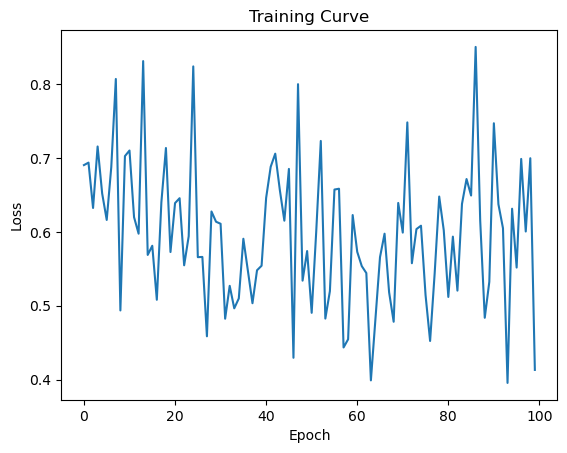

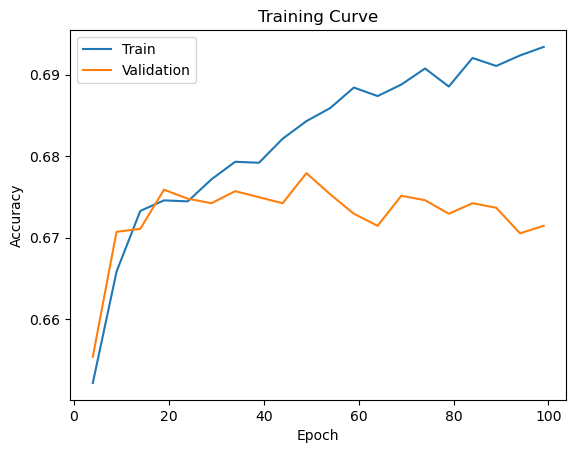

Final test accuracy: 0.6804941002949852


In [47]:
mymodel = nn.Sequential(nn.Linear(50, 30),
                        nn.ReLU(),
                        nn.Linear(30, 10),
                        nn.ReLU(),
                        nn.Linear(10, 2))
train_network(mymodel, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4)
print("Final test accuracy:", get_accuracy(mymodel, test_loader))

In [54]:
def test_model(model, glove_vector, tweet):
    emb = sum(glove_vector[w] for w in split_tweet(tweet))
    out = mymodel(emb.unsqueeze(0))
    pred = out.max(1, keepdim=True)[1]
    return pred

test_model(mymodel, glove, "very happy")

tensor([[1]])

In [49]:
test_model(mymodel, glove, "This is a terrible tragedy")

tensor([[0]])

In [50]:
test_model(mymodel, glove, "okay")

tensor([[0]])

Note that the model does not perform very well, but it does get it right from time to time. There are a number of things we could try to improve the performance, for example changing the number of hidden units, number of layers, or change the dimension of the Glove embeddings.

Another option is to use a more powerful architecture.

# Part C: Recurrent Neural Networks

One of the drawbacks of the previous approach is that the order of
words is lost. The tweets "the cat likes the dog" and "the dog likes the cat"
would have the exact same embedding, even though the sentences have different
meanings.

For this part we will use a **recurrent neural network**. We will treat each tweet
as a **sequence** of words. Like before, we will use GloVe embeddings as inputs
to the recurrent network. (As a sidenote, not all recurrent neural networks use
word embeddings as input. If we had a small enough vocabulary, we could have used
a one-hot embedding of the words.)

In [55]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

# file location (make sure to use your file location)
file_dir = ''

def get_data():
    return csv.reader(open(file_dir + "training.1600000.processed.noemoticon.csv","rt", encoding="latin-1"))

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000) # use 10k most common words

Since we are going to store the individual words in a tweet,
we will defer looking up the word embeddings.
Instead, we will store the **index** of each word in a PyTorch tensor.
Our choice is the most memory-efficient, since it takes fewer bits to
store an integer index than a 50-dimensional vector or a word.

In [56]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        if i % 29 == 0:
            tweet = line[-1]
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(line[0] == "4")).long()
            if i % 5 < 3:
                train.append((idxs, label))
            elif i % 5 == 4:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)

Here's what an element of the training set looks like:

In [81]:
tweet, label = train[0]
print(tweet)
print(label)

tensor([   2,   11,    1,    7,    2,   81,  405,  684, 9912,    3,  245,  122,
           4,   88,   20,    2,   89, 1968])
tensor(0)


Unlike in the past, each element of the training set will have a
different shape. The difference will present some difficulties when
we discuss batching later on.

In [58]:
for i in range(10):
    tweet, label = train[i]
    print(tweet.shape)

torch.Size([18])
torch.Size([23])
torch.Size([8])
torch.Size([20])
torch.Size([6])
torch.Size([5])
torch.Size([10])
torch.Size([8])
torch.Size([7])
torch.Size([31])


## Embedding

We are also going to use an `nn.Embedding` layer, instead of using the variable
`glove` directly. The reason is that the `nn.Embedding` layer allows us look up
the embeddings of multiple words simultaneously.

In [82]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

# Example: we use the forward function of glove_emb to lookup the
# embedding of each word in `tweet`
tweet_emb = glove_emb(tweet)
print(tweet_emb.shape)
print(tweet.shape)

torch.Size([18, 50])
torch.Size([18])


## Recurrent Neural Network Module

PyTorch has variations of recurrent neural network modules.
These modules computes the following:

$$hidden = updatefn(hidden, input)$$
$$output = outputfn(hidden)$$

These modules are more complex and less intuitive than the usual
neural network layers, so let's take a look:

In [60]:
rnn_layer = nn.RNN(input_size=50,    # dimension of the input repr
                   hidden_size=50,   # dimension of the hidden units
                   batch_first=True) # input format is [batch_size, seq_len, repr_dim]

Now, let's try and run this untrained `rnn_layer` on `tweet_emb`.
We will need to add an extra dimension to `tweet_emb` to account for
batching. We will also need to initialize a set of hidden units of size
`[batch_size, 1, repr_dim]`, to be used for the *first* set of computations.

![](imgs/rnn.png)

In [61]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
h0 = torch.zeros(1, 1, 50)           # initial hidden state
out, last_hidden = rnn_layer(tweet_input, h0)

We don't technically have to explictly provide the initial hidden state,
if we want to use an initial state of zeros. Just for today, we will be
explicit about the hidden states that we provide.

In [62]:
out2, last_hidden2 = rnn_layer(tweet_input)

Now, let's look at the output and hidden dimensions that we have:

In [63]:
print(out.shape)
print(last_hidden.shape)

torch.Size([1, 31, 50])
torch.Size([1, 1, 50])


The shape of the hidden units is the same as our initial `h0`.
The variable `out`, though, has the same shape as our `input`.
The variable contains the concatenation of all of the output units
for each word (i.e. at each time point).

Normally, we only care about the output at the **final** time point,
which we can extract like this.

In [64]:
out[:,-1,:]

tensor([[ 0.4295, -0.5046,  0.3924,  0.2680,  0.3922,  0.1064, -0.3805,  0.5011,
         -0.0838, -0.2332,  0.3166,  0.1118,  0.1129,  0.2011,  0.4232,  0.3508,
          0.2631,  0.3229, -0.2839, -0.0195,  0.3977,  0.1732, -0.6294, -0.5050,
         -0.5605,  0.2412, -0.2920, -0.3982,  0.5615, -0.3871,  0.0032,  0.2219,
          0.1404,  0.5225,  0.3903,  0.5217,  0.1788,  0.1009,  0.6621,  0.0792,
          0.6474, -0.4861, -0.2981, -0.1727, -0.3482,  0.4643,  0.6317, -0.2015,
          0.6422,  0.1381]], grad_fn=<SliceBackward0>)

This tensor summarizes the entire tweet, and can be used as an input
to a classifier.

## Building a Model

Let's put both the embedding layer, the RNN and the classifier into one model:

In [65]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = TweetRNN(50, 50, 2)

We should be able to train this model similar to any other model that we have trained before. However, there is one caveat that we have been avoiding this entire time, **batching**.

## Batching

Unfortunately, we will not be able to use `DataLoader` with a
`batch_size` of greater than one. This is because each tweet has
a different shaped tensor.

In [66]:
for i in range(10):
    tweet, label = train[i]
    print(tweet.shape)

torch.Size([18])
torch.Size([23])
torch.Size([8])
torch.Size([20])
torch.Size([6])
torch.Size([5])
torch.Size([10])
torch.Size([8])
torch.Size([7])
torch.Size([31])


PyTorch implementation of `DataLoader` class expects all data samples
to have the same shape. So, if we create a DataLoader like below,
it will throw an error when we try to iterate over its elements.

In [67]:
#will_fail = torch.utils.data.DataLoader(train, batch_size=128)

So, we will need a different way of batching.

One strategy is to **pad shorter sequences with zero inputs**, so that
every sequence is the same length. The following PyTorch utilities
are helpful.

- `torch.nn.utils.rnn.pad_sequence`
- `torch.nn.utils.rnn.pad_packed_sequence`
- `torch.nn.utils.rnn.pack_sequence`
- `torch.nn.utils.rnn.pack_padded_sequence`

(Actually, there are more powerful helpers in the `torchtext` module
that we will use in Lab 5. We'll stick to these in this demo, so that
you can see what's actually going on under the hood.)

In [68]:
from torch.nn.utils.rnn import pad_sequence

tweet_padded = pad_sequence([tweet for tweet, label in train[:10]],
                            batch_first=True)
print(tweet_padded.shape)
print(tweet_padded[0:2])

torch.Size([10, 31])
tensor([[   2,   11,    1,    7,    2,   81,  405,  684, 9912,    3,  245,  122,
            4,   88,   20,    2,   89, 1968,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [ 192,    2,   41, 4284,   83,    0,   31, 1096,    4,   88,   17,   20,
          188,   83,  100,    1,  500,    1,   41,  169,   20,    1,  837,    0,
            0,    0,    0,    0,    0,    0,    0]])


Now, we can pass multiple tweets in a batch through the RNN at once!

In [69]:
out = model(tweet_padded)
print(out.shape)

torch.Size([10, 2])


One issue we overlooked was that in our `TweetRNN` model, we always
take the **last output unit** as input to the final classifier. Now
that we are padding the input sequences, we should really be using
the output at a previous time step. Recurrent neural networks therefore
require much more record keeping than ANNs or even CNNs.

There is yet another problem:
the longest tweet has many, many more words than the shortest.
Padding tweets so that every tweet has the same length as the longest
tweet is impractical. Padding tweets in a mini-batch, however, is much
more reasonable.

In practice, practitioners will batch together tweets with the same
length. For simplicity, we will do the same. We will implement a (more or less)
straightforward way to batch tweets.

In [70]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)

        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}

    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

Let's take a look at our batcher in action. We will set `drop_last` to be true for training,
so that all of our batches have exactly the same size.

In [71]:
for i, (tweets, labels) in enumerate(TweetBatcher(train, drop_last=True)):
    if i > 20: break
    print(tweets.shape, labels.shape)

torch.Size([32, 14]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 31]) torch.Size([32])
torch.Size([32, 19]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 21]) torch.Size([32])
torch.Size([32, 25]) torch.Size([32])
torch.Size([32, 29]) torch.Size([32])
torch.Size([32, 24]) torch.Size([32])
torch.Size([32, 1]) torch.Size([32])
torch.Size([32, 3]) torch.Size([32])
torch.Size([32, 20]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 17]) torch.Size([32])
torch.Size([32, 5]) torch.Size([32])
torch.Size([32, 21]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 17]) torch.Size([32])
torch.Size([32, 15]) torch.Size([32])


Just to verify that our batching is reasonable, here is a modification of the
`get_accuracy` function we wrote last time.

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

test_loader = TweetBatcher(test, batch_size=64, drop_last=False)
get_accuracy(model, test_loader)

0.5018798716185237

Our training code will also be very similar to the code we wrote last time:

In [73]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Let's train our model. Note that there will be some inaccuracies in computing the training loss.
We are dropping some data from the training set by setting `drop_last=True`. Again, the choice is
not ideal, but simplifies our code.

Epoch 1; Loss 0.632902; Train Acc 0.623695; Val Acc 0.625997
Epoch 2; Loss 0.590863; Train Acc 0.652686; Val Acc 0.651389
Epoch 3; Loss 0.572912; Train Acc 0.667070; Val Acc 0.659730
Epoch 4; Loss 0.622139; Train Acc 0.668247; Val Acc 0.662939
Epoch 5; Loss 0.598951; Train Acc 0.668756; Val Acc 0.663489
Epoch 6; Loss 0.595358; Train Acc 0.674166; Val Acc 0.667614
Epoch 7; Loss 0.526804; Train Acc 0.672161; Val Acc 0.664131
Epoch 8; Loss 0.552887; Train Acc 0.668215; Val Acc 0.659639
Epoch 9; Loss 0.621160; Train Acc 0.676235; Val Acc 0.669997
Epoch 10; Loss 0.617727; Train Acc 0.679290; Val Acc 0.671647
Epoch 11; Loss 0.632727; Train Acc 0.682663; Val Acc 0.674031
Epoch 12; Loss 0.528583; Train Acc 0.669997; Val Acc 0.665231
Epoch 13; Loss 0.539782; Train Acc 0.684254; Val Acc 0.678522
Epoch 14; Loss 0.587011; Train Acc 0.684827; Val Acc 0.675497
Epoch 15; Loss 0.532373; Train Acc 0.687086; Val Acc 0.678339
Epoch 16; Loss 0.614527; Train Acc 0.687882; Val Acc 0.679164
Epoch 17; Loss 0.

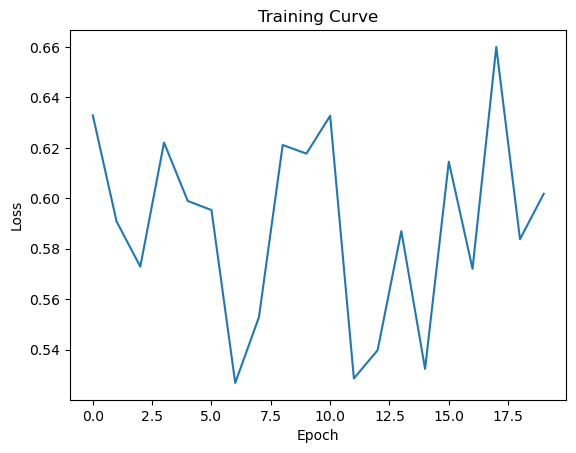

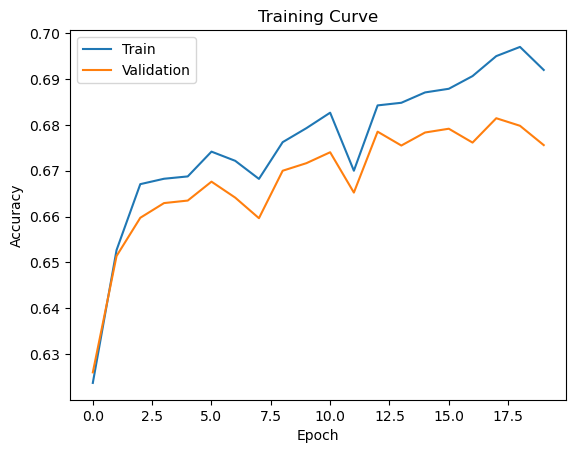

0.6828060522696011

In [74]:
model = TweetRNN(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)

The hidden size and the input embedding size don't have to be the same.

Epoch 1; Loss 0.627619; Train Acc 0.654086; Val Acc 0.652305
Epoch 2; Loss 0.596432; Train Acc 0.654213; Val Acc 0.649097
Epoch 3; Loss 0.666961; Train Acc 0.668852; Val Acc 0.662022
Epoch 4; Loss 0.646055; Train Acc 0.672766; Val Acc 0.663672
Epoch 5; Loss 0.705032; Train Acc 0.667961; Val Acc 0.658539
Epoch 6; Loss 0.672781; Train Acc 0.673593; Val Acc 0.662664
Epoch 7; Loss 0.578084; Train Acc 0.673625; Val Acc 0.665414
Epoch 8; Loss 0.596601; Train Acc 0.671684; Val Acc 0.664314
Epoch 9; Loss 0.623015; Train Acc 0.678208; Val Acc 0.666972
Epoch 10; Loss 0.504109; Train Acc 0.671016; Val Acc 0.661197
Epoch 11; Loss 0.636289; Train Acc 0.678430; Val Acc 0.669447
Epoch 12; Loss 0.581562; Train Acc 0.666879; Val Acc 0.655422
Epoch 13; Loss 0.579348; Train Acc 0.678844; Val Acc 0.666514
Epoch 14; Loss 0.625246; Train Acc 0.681708; Val Acc 0.666147
Epoch 15; Loss 0.664135; Train Acc 0.684954; Val Acc 0.666606
Epoch 16; Loss 0.507957; Train Acc 0.686927; Val Acc 0.665506
Epoch 17; Loss 0.

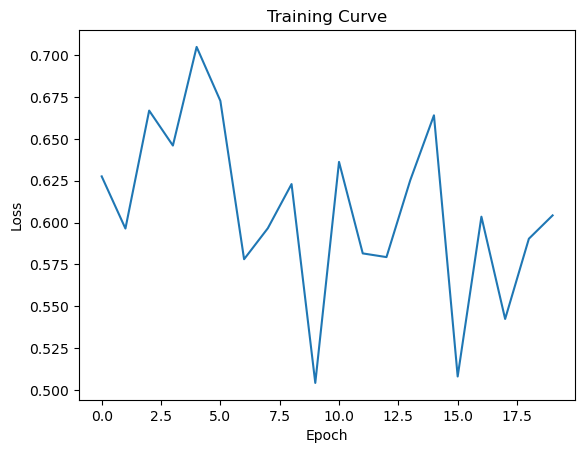

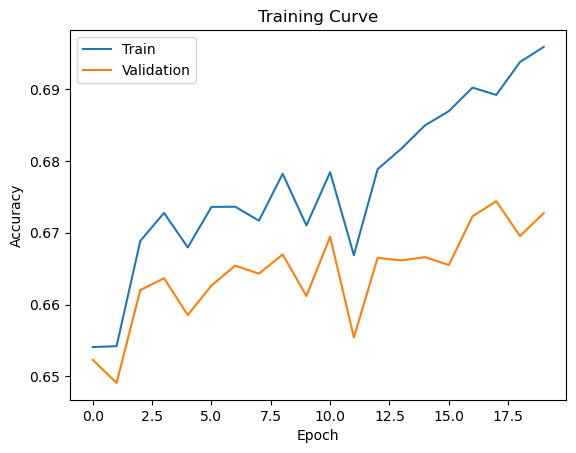

0.6792297111416782

In [75]:
model = TweetRNN(50, 100, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)

##### Sentiment Analysis on New Tweets

In [76]:
def get_new_tweet(glove_vector, sample_tweet):
    tweet = sample_tweet
    idxs = [glove_vector.stoi[w]        # lookup the index of word
            for w in split_tweet(tweet)
            if w in glove_vector.stoi] # keep words that has an embedding
    idxs = torch.tensor(idxs) # convert list to pytorch tensor
    return idxs

In [77]:
new_tweet = get_new_tweet(glove, "This is a terrible tragedy")
print(new_tweet.shape)

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

torch.Size([5])
tensor([[0]])


In [78]:
new_tweet = get_new_tweet(glove, "This is the best day of my life")
print(new_tweet.shape)

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

torch.Size([8])
tensor([[1]])


Sentiment analysis is not a straight forward problem and it's impressive that without too much tunning we are able to get validation accuracy close to 70%. There are many ways that we can improve our performance:

*   Tune hyperparameters
*   Use all of the available data
*   Apply more advanced RNN architectures (ex. LSTM and GRU)

Epoch 1; Loss 0.687086; Train Acc 0.549134; Val Acc 0.546430
Epoch 2; Loss 0.681977; Train Acc 0.582771; Val Acc 0.575121
Epoch 3; Loss 0.691774; Train Acc 0.597823; Val Acc 0.592905
Epoch 4; Loss 0.678221; Train Acc 0.610712; Val Acc 0.605555
Epoch 5; Loss 0.655905; Train Acc 0.623218; Val Acc 0.621872
Epoch 6; Loss 0.629052; Train Acc 0.633783; Val Acc 0.636264
Epoch 7; Loss 0.643446; Train Acc 0.641643; Val Acc 0.641397
Epoch 8; Loss 0.656978; Train Acc 0.648294; Val Acc 0.644880
Epoch 9; Loss 0.629992; Train Acc 0.651508; Val Acc 0.647722
Epoch 10; Loss 0.639382; Train Acc 0.655232; Val Acc 0.649464
Epoch 11; Loss 0.655805; Train Acc 0.658700; Val Acc 0.652580
Epoch 12; Loss 0.654608; Train Acc 0.661692; Val Acc 0.654505
Epoch 13; Loss 0.580100; Train Acc 0.663060; Val Acc 0.655972
Epoch 14; Loss 0.585633; Train Acc 0.664047; Val Acc 0.656155
Epoch 15; Loss 0.579248; Train Acc 0.666592; Val Acc 0.658539
Epoch 16; Loss 0.652537; Train Acc 0.668088; Val Acc 0.659822
Epoch 17; Loss 0.

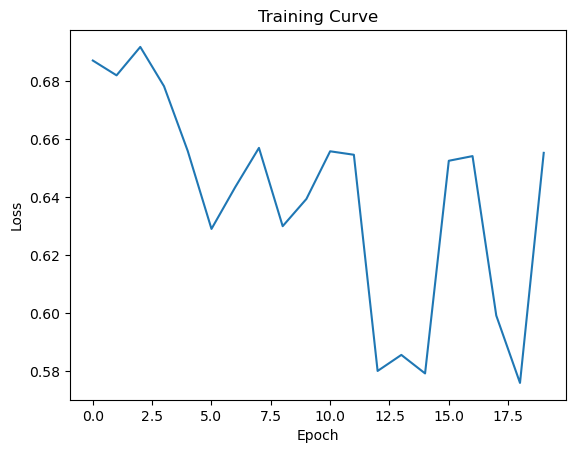

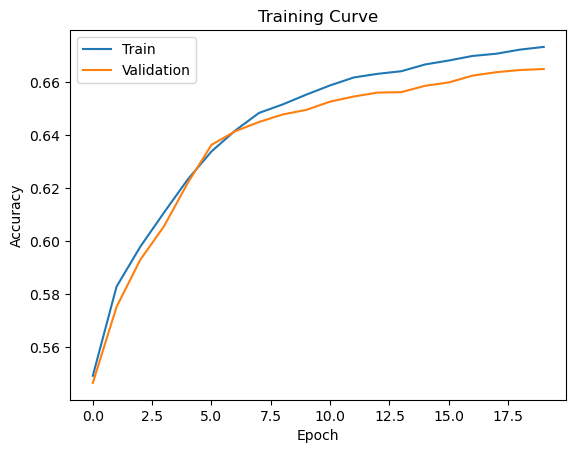

0.6671251719394773

In [79]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = TweetLSTM(50, 50, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
get_accuracy(model, test_loader)